**Architecture **

<img src="http://drive.google.com/uc?export=view&id=12JomC2IswVbNGdE0IIvPpUk8vPjP-MBQ"  alt="artchtecture">


---



(1) Importing dependency

In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


(2) Get Data

In [2]:
base_dir = '/data/private/SU/bbchip13/chainsaw_classification/data/'
train_dir = base_dir+'train/'
val_dir = base_dir+'val/'
test_dir = base_dir+'test/'

In [3]:
def load_wavs(filenames):
    return np.asarray([librosa.load(filename)[0] for filename in tqdm(filenames)])

### If you have lack of memory, Use this
#     wav = librosa.load(filenames[0])
#     wavs = np.zeros( (len(filenames), wav.shape[0]) )
#     for i, filename in enumerate(filenames):
#         wavs[i][:] = librosa.load(filename)[:]
#     return wavs
    
def find_y_by_filename(filename, y_dict):
    basename = os.path.basename(filename)
    y = y_dict[basename]
    return y

def make_y_by_filenames(filenames, y_dict):
    return np.asarray([find_y_by_filename(filename, y_dict) 
                           for filename in filenames])

def make_xy_data(filenames, y_dict):
    x_train = load_wavs(filenames)
    x_train = np.reshape(x_train, (*x_train.shape, 1))
    y_train = make_y_by_filenames(filenames, y_dict)
    return x_train, y_train

In [4]:
### Make Y data
annotations_filename = 'data_annotations.csv'
df = pd.read_csv(annotations_filename)
y_dict = {filename:int(label) for _, filename, label, _ in df.itertuples()}
# y_dict

In [5]:
print('Make train data.......')
x_train_wav_filenames = [train_dir+filename for filename in os.listdir(train_dir)
                            if filename.endswith('.wav')]#[:1000]
x_train, y_train = make_xy_data(x_train_wav_filenames, y_dict)

print('Make validation data.......')
x_val_wav_filenames = [val_dir+filename for filename in os.listdir(val_dir)
                            if filename.endswith('.wav')]#[:200]
x_val, y_val = make_xy_data(x_val_wav_filenames, y_dict)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

Make train data.......



Make validation data.......



(1543, 110250, 1) (1543,) (714, 110250, 1) (714,)


(3) Create a sequential model

In [6]:
### Define Parametric Softplus

# alpha * log(1 + exp(beta * x))
def ParametricSoftplus(alpha=0.2, beta=5.0):
  return lambda x: alpha * keras.activations.softplus(beta * x)

In [7]:
model=Sequential()

# 1st Convolutional Layer (conv1)
model.add(Conv1D (kernel_size=121, filters=48, strides=16, padding='same',
#                   input_shape=x_train.shape[1:]))
                  input_shape=(110250, 1)))

model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool1)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 2nd Convolutional Layer (conv2)
model.add(Conv1D (kernel_size=25, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool2)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 3rd Convolutional Layer (conv3)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 4rd Convolutional Layer (conv4)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 5rd Convolutional Layer (conv5)
model.add(Conv1D (kernel_size=9, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# Pooling (pool5)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 1st Dense Layer (full6)
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5)) # Drop-out value is not specified in the paper

# 2nd Dense Layer (full7)
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5))

# Output Layer (full8)
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6891, 48)          5856      
_________________________________________________________________
activation_1 (Activation)    (None, 6891, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6891, 48)          192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1723, 48)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1723, 128)         153728    
_________________________________________________________________
activation_2 (Activation)    (None, 1723, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1723, 128)         512       
__________

(4) Compile 

In [8]:
adam_with_params = keras.optimizers.Adam(lr=0.0002, beta_1=0.1, beta_2=0.999, 
                                         epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=adam_with_params,
              metrics=['accuracy'])

(5) Train

In [9]:
model_path = 'AlexNet_based_check_point/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [10]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=10000, validation_data=[x_val, y_val], 
                 shuffle=True, callbacks = [checkpointer, early_stopping])

Train on 1543 samples, validate on 714 samples
Epoch 1/10000
1543/1543 [==============================] - 9s 6ms/step - loss: 0.6496 - acc: 0.6507 - val_loss: 0.8408 - val_acc: 0.6218

Epoch 00001: val_loss improved from inf to 0.84076, saving model to AlexNet_based_check_point/01-0.8408.hdf5
Epoch 2/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.4826 - acc: 0.7732 - val_loss: 0.7537 - val_acc: 0.7395

Epoch 00002: val_loss improved from 0.84076 to 0.75373, saving model to AlexNet_based_check_point/02-0.7537.hdf5
Epoch 3/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.2578 - acc: 0.9151 - val_loss: 0.3216 - val_acc: 0.8824

Epoch 00003: val_loss improved from 0.75373 to 0.32160, saving model to AlexNet_based_check_point/03-0.3216.hdf5
Epoch 4/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.2076 - acc: 0.9255 - val_loss: 0.2899 - val_acc: 0.9048

Epoch 00004: val_loss improved from 0.32160 to 0.28991, saving mod

1543/1543 [==============================] - 4s 3ms/step - loss: 0.0565 - acc: 0.9767 - val_loss: 0.1724 - val_acc: 0.9538

Epoch 00040: val_loss did not improve from 0.14599
Epoch 41/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0677 - acc: 0.9741 - val_loss: 0.1921 - val_acc: 0.9524

Epoch 00041: val_loss did not improve from 0.14599
Epoch 42/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0636 - acc: 0.9734 - val_loss: 0.1505 - val_acc: 0.9496

Epoch 00042: val_loss did not improve from 0.14599
Epoch 43/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0613 - acc: 0.9806 - val_loss: 0.1788 - val_acc: 0.9524

Epoch 00043: val_loss did not improve from 0.14599
Epoch 44/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0606 - acc: 0.9773 - val_loss: 0.1959 - val_acc: 0.9482

Epoch 00044: val_loss did not improve from 0.14599
Epoch 45/10000
1543/1543 [==============================] - 4s 3m

1543/1543 [==============================] - 4s 3ms/step - loss: 0.1980 - acc: 0.9553 - val_loss: 0.2605 - val_acc: 0.9328

Epoch 00083: val_loss did not improve from 0.14564
Epoch 84/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0537 - acc: 0.9799 - val_loss: 0.2046 - val_acc: 0.9426

Epoch 00084: val_loss did not improve from 0.14564
Epoch 85/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0590 - acc: 0.9780 - val_loss: 0.1609 - val_acc: 0.9524

Epoch 00085: val_loss did not improve from 0.14564
Epoch 86/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0456 - acc: 0.9831 - val_loss: 0.1685 - val_acc: 0.9496

Epoch 00086: val_loss did not improve from 0.14564
Epoch 87/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0484 - acc: 0.9825 - val_loss: 0.1496 - val_acc: 0.9440

Epoch 00087: val_loss did not improve from 0.14564
Epoch 88/10000
1543/1543 [==============================] - 4s 3m

1543/1543 [==============================] - 4s 3ms/step - loss: 0.0625 - acc: 0.9806 - val_loss: 0.1889 - val_acc: 0.9524

Epoch 00126: val_loss did not improve from 0.14503
Epoch 127/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0297 - acc: 0.9916 - val_loss: 0.1897 - val_acc: 0.9510

Epoch 00127: val_loss did not improve from 0.14503
Epoch 128/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0205 - acc: 0.9916 - val_loss: 0.2230 - val_acc: 0.9510

Epoch 00128: val_loss did not improve from 0.14503
Epoch 129/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0239 - acc: 0.9903 - val_loss: 0.2596 - val_acc: 0.9524

Epoch 00129: val_loss did not improve from 0.14503
Epoch 130/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0395 - acc: 0.9838 - val_loss: 0.2150 - val_acc: 0.9566

Epoch 00130: val_loss did not improve from 0.14503
Epoch 131/10000
1543/1543 [==============================] - 

1543/1543 [==============================] - 4s 3ms/step - loss: 0.0126 - acc: 0.9961 - val_loss: 0.2629 - val_acc: 0.9496

Epoch 00169: val_loss did not improve from 0.14503
Epoch 170/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0097 - acc: 0.9968 - val_loss: 0.2696 - val_acc: 0.9510

Epoch 00170: val_loss did not improve from 0.14503
Epoch 171/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0140 - acc: 0.9942 - val_loss: 0.2141 - val_acc: 0.9552

Epoch 00171: val_loss did not improve from 0.14503
Epoch 172/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0266 - acc: 0.9916 - val_loss: 0.2505 - val_acc: 0.9454

Epoch 00172: val_loss did not improve from 0.14503
Epoch 173/10000
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0081 - acc: 0.9987 - val_loss: 0.2473 - val_acc: 0.9510

Epoch 00173: val_loss did not improve from 0.14503
Epoch 174/10000
1543/1543 [==============================] - 

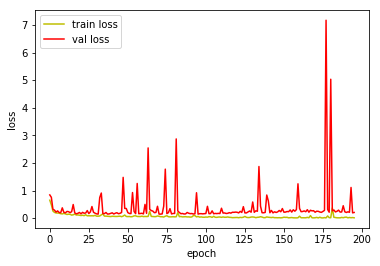

In [11]:
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

(6) Test

In [12]:
print('Make test data.......')
x_test_wav_filenames = [test_dir+filename for filename in os.listdir(test_dir)
                            if filename.endswith('.wav')]
x_test, y_test = make_xy_data(x_test_wav_filenames, y_dict)

Make test data.......


In [14]:
model = load_model(model_path+'96-0.1450.hdf5',custom_objects={'<lambda>': ParametricSoftplus(0.2, 0.5)})

In [15]:
[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

1054/1054 [==============================] - 1s 1ms/step
Loss: 0.09208296200497326 Accuracy: 0.9705882352941176


In [16]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

F1 Score: 0.9756480754124115


In [17]:
%timeit -n 5 -r 5 model.predict(x_test)

783 ms ± 13 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
